# XGBoost による顧客離反分析 (Churn Analysis)

---

---

## コンテンツ

1. [背景](#1.背景)
1. [セットアップ](#2.セットアップ)
1. [データ](#3.データ)
1. [学習](#4.学習)
1. [ホスティング](#5.ホスティング)
  1. [評価](#5-1.評価)
  1. [推論エラーのコスト](#5-2.推論エラーのコスト)
  1. [最適な閾値を探す](#5-3.最適な閾値を探す)
1. [エンドポイントの削除](#6.エンドポイントの削除)
---

## 1.背景

_このノートブックで実施する内容は、[AWS blog post](https://aws.amazon.com/blogs/ai/predicting-customer-churn-with-amazon-machine-learning/)にも記載されています。_

どのようなビジネスであっても、顧客を失うことは大きな損害です。もし、満足していない顧客を早期に見つけることができれば、そのような顧客をキープするためのインセンティブを提供できる可能性があるでしょう。このノートブックでは、満足していない顧客を自動で認識するために機械学習 (Machine Learning, ML) を利用する方法を説明します。このような顧客の離反分析は Customer Churn Prediction と呼ばれています。機械学習モデルは完璧な予測を行えないので、このノートブックでは予測のエラーが生じたときの相対的なコストを考慮して、機械学習を利用したときの成果を金額で評価します。

ここでは、私達にとってなじみのある離反分析、携帯電話会社からの離反を取り上げます。携帯電話会社が、ある顧客が離反しそうと察知したら、その顧客にタイムリーにインセンティブを与えます。つまり、電話をアップグレードしたり、新しい機能を使えるようになったりして、引き続き携帯電話会社を使おうと思うかもしれません。インセンティブは、顧客が離反して再度獲得するまでにかかるコストよりもずっと小さいことが多いです。



---

## 2.セットアップ

### 2-1.開発環境のセットアップ
Conda で開発環境を作成しましょう。 environment.yml を右クリックして`Build Conda Environment`をクリックすると環境が構築できます。

![environment_setup_001.png](./images/001.png)


完了したら、Jupyter Notebookの右上にある虫の隣のボタンをクリックしカーネルを切り替えます(作成した仮想環境が反映されるまでに少し時間がかかります)。

![environment_setup_002.png](./images/002.png)


ターミナルから環境を構築する場合は、[こちら](https://github.com/aws-samples/aws-ml-enablement-workshop/blob/main/notebooks/00_environment_setup.ipynb)をご確認ください。

### 2-2. ライブラリの読み込み
以降で利用するライブラリをここで読み込んでおきます。

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
from time import strftime, gmtime
import xgboost

---
## 3.データ

携帯電話会社は、どの顧客が最終的に離反したか、または、サービスを使い続けたかの履歴データをもっています。この履歴データに対して学習を行うことで、携帯電話会社の顧客離反を予想するモデルを構築します。モデルの学習が終わった後、任意の顧客のデータ (モデルの学習で利用したものと同じ情報を利用します）をモデルに入力すると、モデルはその顧客が離反しそうかどうかを予測します。もちろん、モデルは誤って予測することも考えられるので、将来を予測することはやはり難しいですが、そのような誤りに対応する方法も紹介します。

ここで利用するデータセットは一般的に利用可能で、書籍 [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) の中で Daniel T. Larose が言及しているものです。そのデータセットは、著者によって University of California Irvine Repository of Machine Learning Datasets に提供されています。ここでは、そのデーセットをダウンロードして読み込んでみます。

カレントディレクトリ下にダウンロードされた `churn.txt` を `pandas` を利用して読み込んでみます。 `pandas` は、表形式のデータを読み込んで、様々な加工ができるライブラリです。例えば、以下を実行すると表形式でのデータ表示が可能です。

In [40]:
data_root = Path("../../data/")
churn = pd.read_csv(data_root.joinpath("raw/churn.txt"))
pd.set_option('display.max_columns', 500)
churn

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,PA,163,806,403-2562,no,yes,300,8.162204,3,7.579174,3.933035,4,6.508639,4.065759,100,5.111624,4.928160,6,5.673203,3,True.
1,SC,15,836,158-8416,yes,no,0,10.018993,4,4.226289,2.325005,0,9.972592,7.141040,200,6.436188,3.221748,6,2.559749,8,False.
2,MO,131,777,896-6253,no,yes,300,4.708490,3,4.768160,4.537466,3,4.566715,5.363235,100,5.142451,7.139023,2,6.254157,4,False.
3,WY,75,878,817-5729,yes,yes,700,1.268734,3,2.567642,2.528748,5,2.333624,3.773586,450,3.814413,2.245779,6,1.080692,6,False.
4,WY,146,878,450-4942,yes,no,0,2.696177,3,5.908916,6.015337,3,3.670408,3.751673,250,2.796812,6.905545,4,7.134343,6,True.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,NH,4,787,151-3162,yes,yes,800,10.862632,5,7.250969,6.936164,1,8.026482,4.921314,350,6.748489,4.872570,8,2.122530,9,False.
4996,SD,140,836,351-5993,no,no,0,1.581127,8,3.758307,7.377591,7,1.328827,0.939932,300,4.522661,6.938571,2,4.600473,4,False.
4997,SC,32,836,370-3127,no,yes,700,0.163836,5,4.243980,5.841852,3,2.340554,0.939469,450,5.157898,4.388328,7,1.060340,6,False.
4998,MA,142,776,604-2108,yes,yes,600,2.034454,5,3.014859,4.140554,3,3.470372,6.076043,150,4.362780,7.173376,3,4.871900,7,True.


データをみると 5,000 行のデータしかなく、現在の機械学習の状況から見ると、やや小さいデータセットです。各データのレコードは、ある米国の携帯電話会社の顧客のプロフィールを説明する21の属性からなります。その属性というのは、

- `State`: 顧客が居住している米国州で、2文字の省略形で記載されます (OHとかNJのように)
- `Account Length`: アカウントが利用可能になってからの経過日数
- `Area Code`: 顧客の電話番号に対応する3桁のエリアコード
- `Phone`: 残りの7桁の電話番号
- `Int’l Plan`: 国際電話のプランに加入しているかどうか (yes/no)
- `VMail Plan`: Voice mail の機能を利用しているかどうか (yes/no)
- `VMail Message`: 1ヶ月の Voice mail のメッセージの平均長
- `Day Mins`: 1日に通話した時間(分)の総和
- `Day Calls`: 1日に通話した回数の総和
- `Day Charge`: 日中の通話にかかった料金
- `Eve Mins, Eve Calls, Eve Charge`: 夜間通話にかかった料金
- `Night Mins`, `Night Calls`, `Night Charge`: 深夜通話にかかった料金
- `Intl Mins`, `Intl Calls`, `Intl Charge`: 国際通話にかかった料金
- `CustServ Calls`: カスタマーサービスに電話をかけた回数
- `Churn?`: そのサービスから離反したかどうか (true/false)

最後の属性 `Churn?` は目的変数として知られ、MLのモデルで予測する属性になります。目的変数は2値 (binary) なので、ここで作成するモデルは2値の予測を行います。これは2値分類といわれます。

それではデータを詳しく見てみます。

まずは各列のデータ型を確認します。ここで、カテゴリデータは、`State`, `Area code`, `Phone`, `Int’l Plan`, `VMail Plan`, `Churn?`で、カテゴリを表す文字列や数値がデータとして与えられているものです。`pandas`ではある程度自動で、カテゴリデータを認識し、`object`というタイプでデータを保存します。


In [41]:
churn.dtypes

State              object
Account Length      int64
Area Code           int64
Phone              object
Int'l Plan         object
VMail Plan         object
VMail Message       int64
Day Mins          float64
Day Calls           int64
Day Charge        float64
Eve Mins          float64
Eve Calls           int64
Eve Charge        float64
Night Mins        float64
Night Calls         int64
Night Charge      float64
Intl Mins         float64
Intl Calls          int64
Intl Charge       float64
CustServ Calls      int64
Churn?             object
dtype: object

以下では、`object` 形式のデータをとりだして、カテゴリごとの頻度を表示します。
また `describe()`を利用すると各属性の統計量を一度に見ることができます。

In [42]:
# Frequency tables for each categorical feature
for column in churn.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=churn[column], columns='% observations', normalize='columns'))
    
display(churn.select_dtypes(include=['object']).describe())

col_0,% observations
State,
AK,0.0170
AL,0.0200
AR,0.0220
AZ,0.0180
CA,0.0208
CO,0.0182
CT,0.0178
DC,0.0224
DE,0.0182


col_0,% observations
Phone,
100-2030,0.0002
100-2118,0.0002
100-3505,0.0002
100-5224,0.0002
101-3371,0.0002
...,...
999-3178,0.0002
999-5498,0.0002
999-5816,0.0002


col_0,% observations
Int'l Plan,
no,0.5014
yes,0.4986


col_0,% observations
VMail Plan,
no,0.4976
yes,0.5024


col_0,% observations
Churn?,
False.,0.5004
True.,0.4996


,State,Phone,Int'l Plan,VMail Plan,Churn?
count,5000,5000,5000,5000,5000
unique,51,4999,2,2,2
top,RI,614-5668,no,yes,False.
freq,120,2,2507,2512,2502


それでは次に各属性の値を、目的変数の True か False か、にわけて見てみます。

In [43]:
for column in churn.select_dtypes(include=['object']).columns:
    if column != 'Churn?':
        display(pd.crosstab(index=churn[column], columns=churn['Churn?'], normalize='columns'))

Churn?,False.,True.
State,,
AK,0.015588,0.018415
AL,0.021583,0.018415
AR,0.022782,0.021217
AZ,0.015588,0.020416
CA,0.020384,0.021217
CO,0.018785,0.017614
CT,0.015588,0.020016
DC,0.022382,0.022418
DE,0.018385,0.018014


Churn?,False.,True.
Phone,,
100-2030,0.0000,0.0004
100-2118,0.0004,0.0000
100-3505,0.0004,0.0000
100-5224,0.0000,0.0004
101-3371,0.0004,0.0000
...,...,...
999-3178,0.0004,0.0000
999-5498,0.0000,0.0004
999-5816,0.0004,0.0000


Churn?,False.,True.
Int'l Plan,,
no,0.5,0.502802
yes,0.5,0.497198


Churn?,False.,True.
VMail Plan,,
no,0.496403,0.498799
yes,0.503597,0.501201


データを見てみると以下のことに気づくと思います。

- `State` の各頻度はだいたい一様に分布しています。
- `Phone` はすべて同じ数値になっていて手がかりになりそうにありません。この電話番号の最初の3桁はなにか意味がありそうですが、その割当に意味がないのであれば、使うのは止めるべきでしょう
- 数値的な特徴量は都合の良い形で分布しており、多くは釣り鐘のようなガウス分布をしています。ただ、`VMail Message`は例外です。
- `Area code` は数値データとみなされているようなので、非数値に変換しましょう

さて、実際に`Phone`の列を削除して、`Area code`を非数値に変換します。

In [44]:
churn = churn.drop('Phone', axis=1)
churn['Area Code'] = churn['Area Code'].astype(object)

続いて、数値のデータに関して統計量とデータの分布を確認します。

,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,101.675800,226.680000,5.518757,3.50460,5.018902,5.026199,3.140400,5.017557,4.000917,224.790000,5.023490,5.025876,5.475400,4.328242,5.525800
std,57.596762,273.998527,3.433485,1.68812,2.195759,2.135487,2.525621,2.127857,1.631001,97.302875,1.748900,1.019302,1.877045,2.440311,2.041217
min,1.000000,0.000000,0.000215,0.00000,0.004777,0.004659,0.000000,0.013573,0.008468,0.000000,0.054863,1.648514,0.000000,0.000769,0.000000
25%,52.000000,0.000000,2.682384,2.00000,3.470151,3.588466,1.000000,3.529613,2.921998,150.000000,3.873157,4.349726,4.000000,2.468225,4.000000
50%,102.000000,0.000000,5.336245,3.00000,4.988291,5.145656,3.000000,5.006860,3.962089,200.000000,5.169154,5.034905,5.000000,4.214058,6.000000
75%,151.000000,400.000000,7.936151,5.00000,6.559750,6.552962,5.000000,6.491725,5.100128,300.000000,6.272015,5.716386,7.000000,5.960654,7.000000
max,200.000000,1300.000000,16.897529,10.00000,12.731936,13.622097,14.000000,12.352871,10.183378,550.000000,10.407778,8.405644,12.000000,14.212261,13.000000


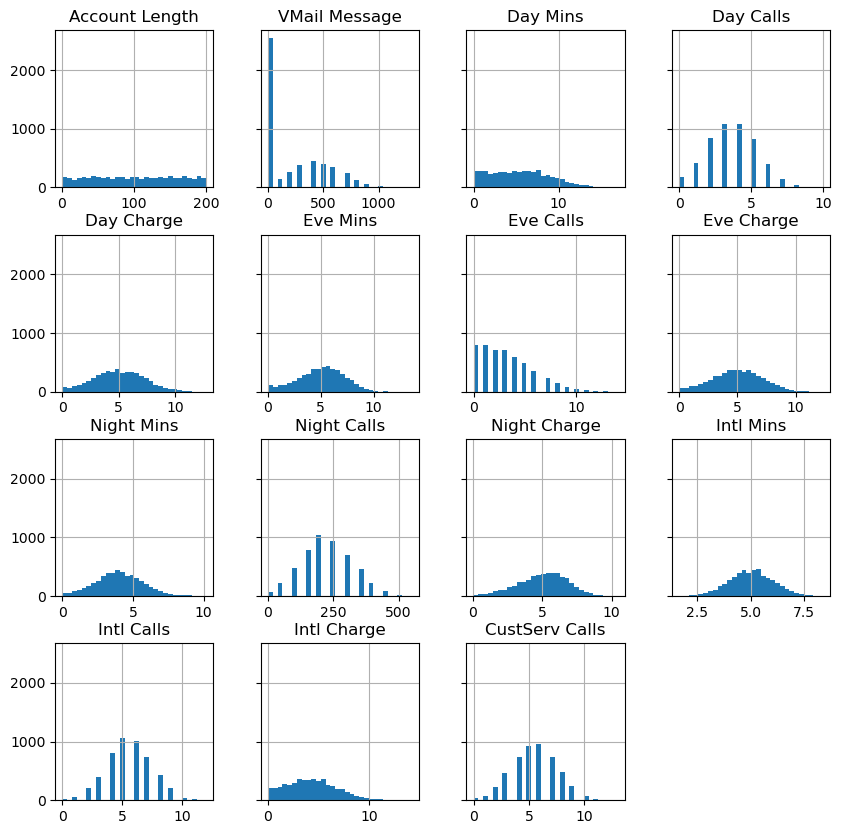

In [45]:
display(churn.select_dtypes(exclude=['object']).describe())
%matplotlib inline
hist = churn.select_dtypes(exclude=['object']).hist(bins=30, sharey=True, figsize=(10, 10))

Account Length


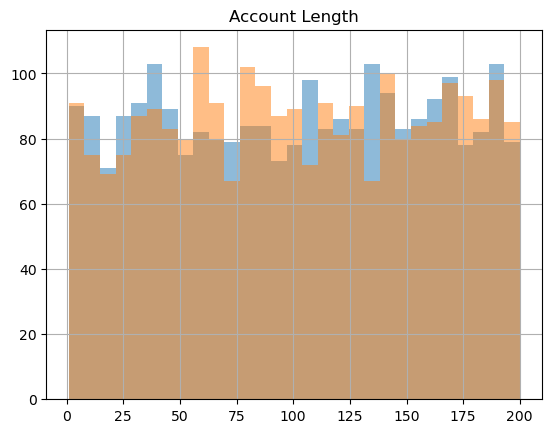

VMail Message


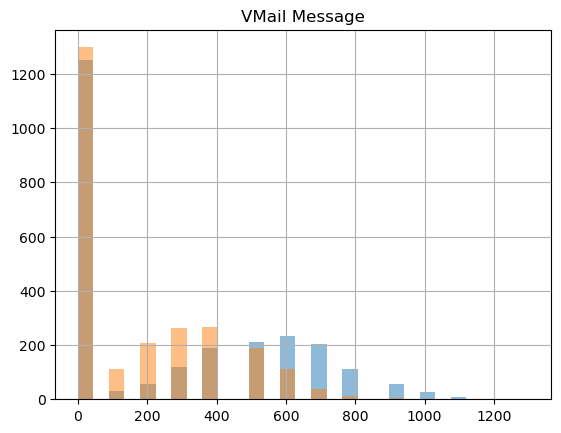

Day Mins


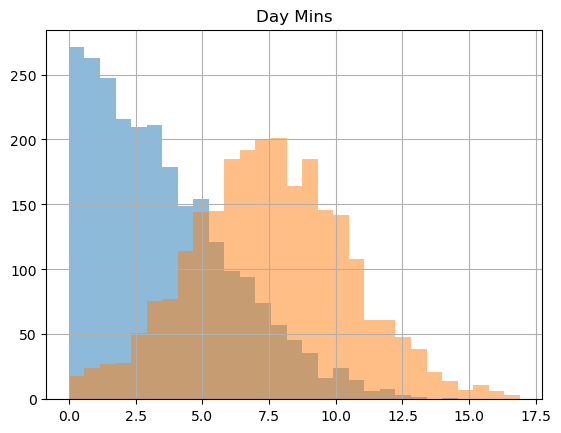

Day Calls


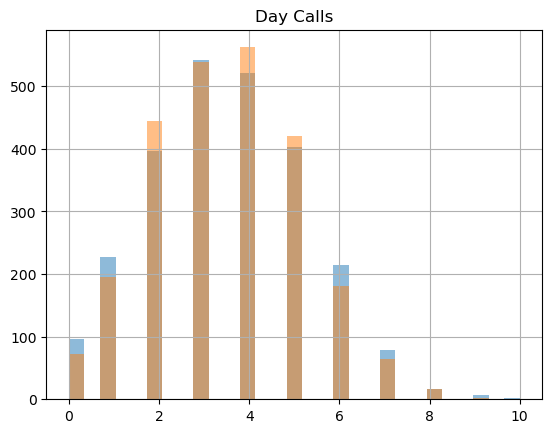

Day Charge


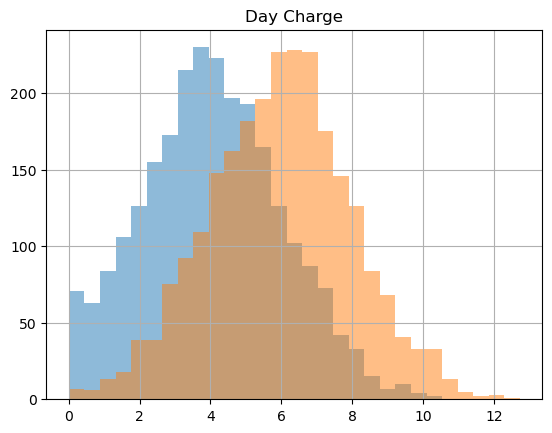

Eve Mins


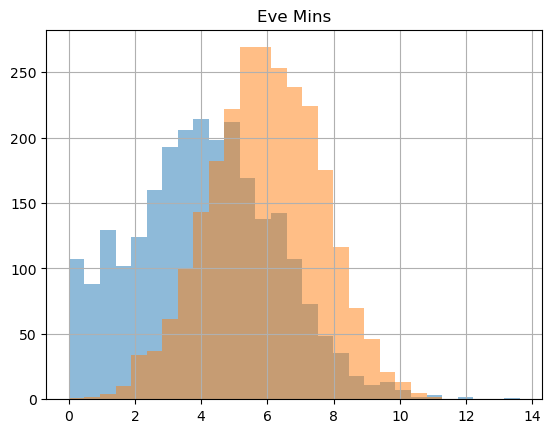

Eve Calls


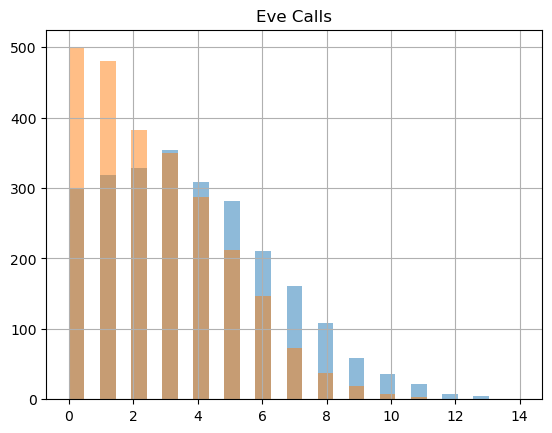

Eve Charge


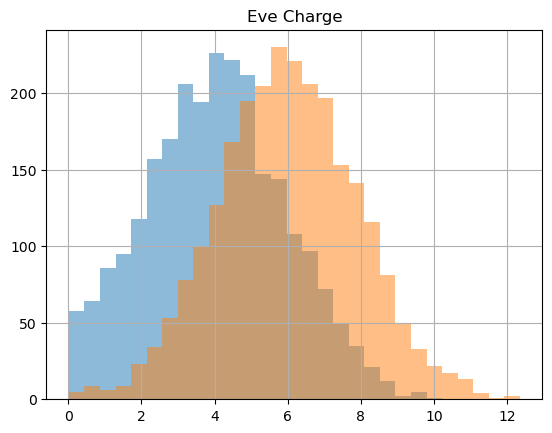

Night Mins


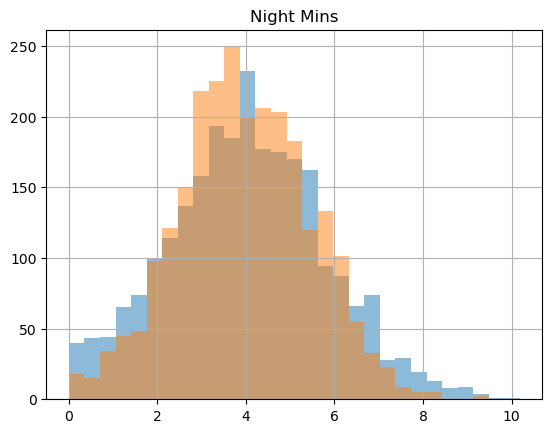

Night Calls


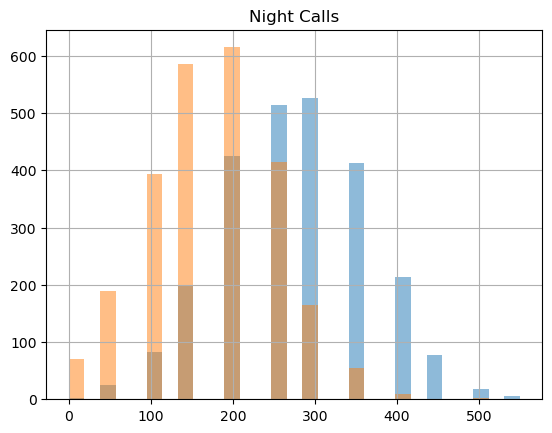

Night Charge


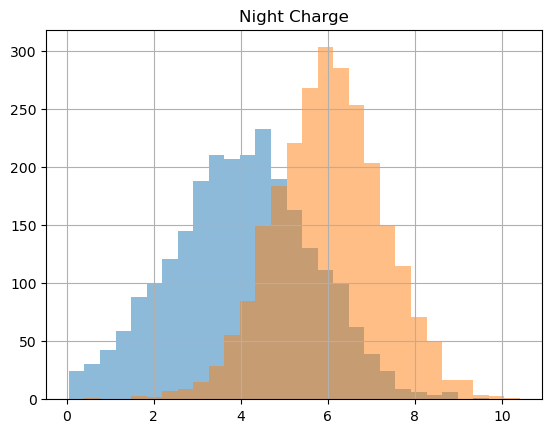

Intl Mins


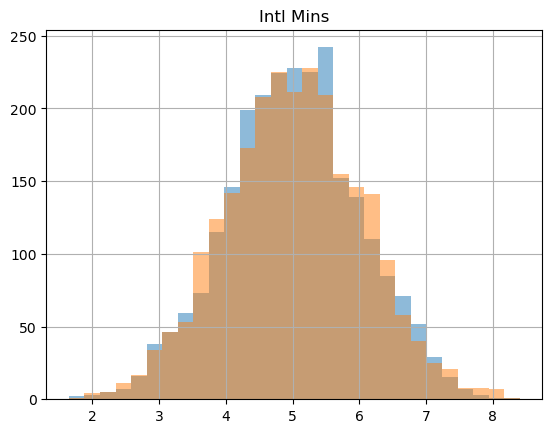

Intl Calls


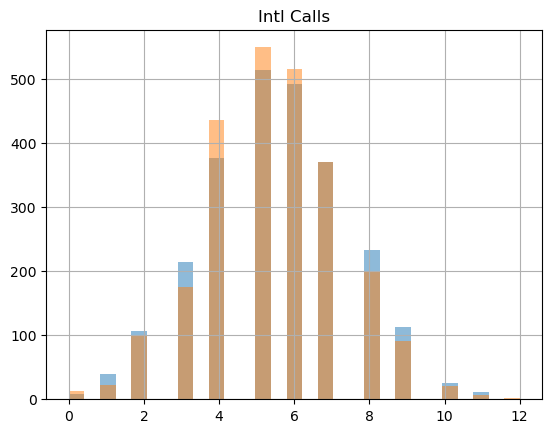

Intl Charge


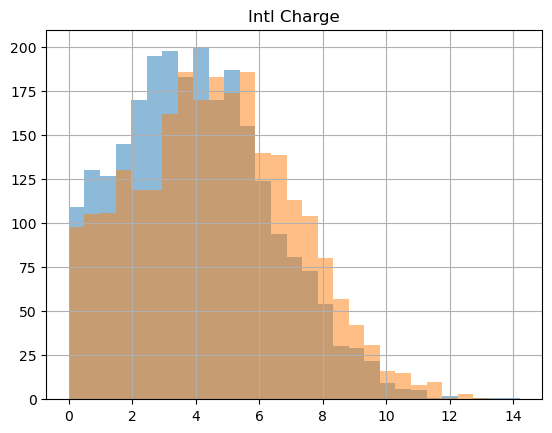

CustServ Calls


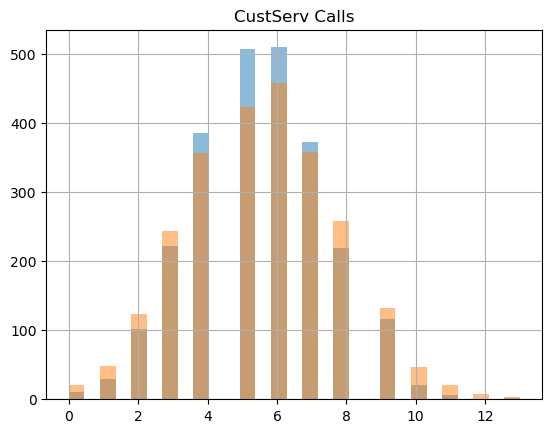

In [46]:
for column in churn.select_dtypes(exclude=['object']).columns:
    print(column)

    ax = plt.subplot()
    hist = churn.loc[:,[column, 'Churn?']].groupby('Churn?').hist(bins=np.linspace(churn[column].min(), churn[column].max(), 30), ax=ax, alpha=0.5)
    plt.show()

データ分析の結果から、離反する顧客について、以下のような傾向が考えられます。

- 地理的にもほぼ一様に分散している
- 国際通話を利用している
- VoiceMailを利用していない
- 通話時間で見ると長い通話時間と短い通話時間の人に分かれる
- カスタマーサービスへの通話が多い (多くの問題を経験した顧客ほど離反するというのは理解できる)

加えて、離反する顧客に関しては、`Day Mins` と `Day Charge` で似たような分布を示しています。しかし、話せば話すほど、通常課金されるので、驚くことではないです。もう少し深く調べてみましょう。`corr()` を利用すると相関係数を求めることができます。

In [47]:
corr = churn.corr()
corr.style.background_gradient(cmap="Greens").set_precision(2)

C:\Users\ttaakkaa\AppData\Local\Temp\ipykernel_18188\173422500.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap="Greens").set_precision(2)


,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
Account Length,1.00,-0.01,-0.02,0.01,-0.01,0.00,0.03,-0.01,0.02,-0.00,-0.03,0.02,-0.00,0.03,-0.04
VMail Message,-0.01,1.00,-0.14,0.00,-0.18,-0.10,-0.10,-0.03,0.06,0.14,-0.16,-0.02,0.13,0.01,0.07
Day Mins,-0.02,-0.14,1.00,-0.09,0.67,0.48,-0.18,0.77,0.19,-0.45,0.57,0.00,0.24,0.24,-0.20
Day Calls,0.01,0.00,-0.09,1.00,-0.22,0.03,0.19,-0.05,-0.09,-0.08,0.05,-0.02,-0.05,-0.12,-0.07
Day Charge,-0.01,-0.18,0.67,-0.22,1.00,0.57,0.24,0.37,0.15,-0.13,0.37,0.01,0.12,0.25,-0.26
Eve Mins,0.00,-0.10,0.48,0.03,0.57,1.00,-0.07,0.27,-0.09,0.07,0.32,-0.02,0.07,0.45,-0.17
Eve Calls,0.03,-0.10,-0.18,0.19,0.24,-0.07,1.00,-0.47,0.22,0.22,-0.32,-0.00,-0.11,0.02,-0.43
Eve Charge,-0.01,-0.03,0.77,-0.05,0.37,0.27,-0.47,1.00,0.18,-0.45,0.55,-0.00,0.16,0.24,-0.01
Night Mins,0.02,0.06,0.19,-0.09,0.15,-0.09,0.22,0.18,1.00,-0.22,-0.14,-0.01,0.04,0.27,-0.33
Night Calls,-0.00,0.14,-0.45,-0.08,-0.13,0.07,0.22,-0.45,-0.22,1.00,-0.39,-0.01,0.18,-0.16,0.11


いくつかの特徴は互いに100%の相関をもっています。このような特徴があるとき、機械学習のアルゴリズムによっては全くうまくいかないことがあり、そうでなくても結果が偏ったりしてしまうことがあります。これらの相関の強いペアは削除しましょう。Day Mins に対する Day Charge、Night Mins に対する Night Charge、Intl Mins に対する Intl Charge を削除します。

In [48]:
churn = churn.drop(['Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge'], axis=1)

ここまででデータセットの前処理は完了です。これから利用する機械学習のアルゴリズムを決めましょう。前述したように、数値の大小 (中間のような数値ではなく)で離反を予測するような変数を用意すると良さそうです。線形回帰のようなアルゴリズムでこれを行う場合は、複数の項（もしくはそれらをまとめた項）を属性として用意する必要があります。

そのかわりに、ここでは勾配ブースティング木 (Gradient Boosted Tree)を利用しましょう。XGBoost は、特徴感の非線形な関係を考慮した勾配ブースティング木を利用しており、特徴間の複雑な関連性を扱うことができます。

まずはじめに、カテゴリ変数を数値データに変換する必要があります。`get_dummies()` を利用すると数値データへの変換が可能です。

そして、`Churn?_True`のデータを最初の列にもってきて、`Churn?_False.`, `Churn?_True.`のデータを削除した残りのデータをconcatenate (連結) します。



In [49]:
model_data = pd.get_dummies(churn)
model_data = pd.concat([model_data['Churn?_True.'], model_data.drop(['Churn?_False.', 'Churn?_True.'], axis=1)], axis=1)

C:\tools\miniconda3\envs\ml-handson-churn\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


ここで学習用、バリデーション用、テスト用データにわけましょう。これによって overfitting (学習用データには精度が良いが、実際に利用すると制度が悪い、といった状況) を回避しやすくなり、未知のテストデータに対する精度を確認することができます。

In [50]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
train_data.to_csv(data_root.joinpath("interim/churn_train.csv"), header=False, index=False)
validation_data.to_csv(data_root.joinpath("interim/churn_validation.csv"), header=False, index=False)
test_data.to_csv(data_root.joinpath("interim/churn_test.csv"), header=False, index=False)

学習には学習用データとバリデーション用データのみが必要です。上で csv に出力したデータをS3にアップロードして学習に利用できるようにします。

---
## 4.学習

それでは学習を始めましょう。まず、説明変数と目的変数にデータを分けます。

In [51]:
train_x, train_y = train_data.drop(['Churn?_True.'], axis=1), train_data['Churn?_True.']
test_x, test_y = test_data.drop(['Churn?_True.'], axis=1), test_data['Churn?_True.']

XGBoost のモデルを作成し、学習を開始します

In [52]:
# xgboostモデルの作成
clf = xgboost.XGBClassifier()
# xgboostモデルの学習
clf.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

---
## 5.評価と考察
### 5-1.評価

In [53]:
predictions = clf.predict_proba(test_x)
predictions = predictions[:, 1]

機械学習の性能を比較評価する方法はいくつかありますが、単純に、予測値と実際の値を比較しましょう。今回は、顧客が離反する `1` と離反しない `0` を予測しますので、この混同行列を作成します。混合行列は以下のように表されます。

![environment_setup_003.png](./images/003.png)


In [54]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,237,16
1,10,237


_注意点, アルゴリズムにはランダムな要素があるので結果は必ずしも一致しません._

247人の離反者がいて、それらの237名 (true positives) を正しく予測できました。そして、16名の顧客は離反すると予測しましたが、離反していません (false positives)。10名の顧客は離反しないと予測したにもかかわらず離反してしまいました (false negatives)。

重要な点として、離反するかどうかを `np.round()` という関数で、しきい値0.5で判断しています。`xgboost` が出力する値は0から1までの連続値で、それらを離反する `1` と 離反しない `0` に分類します。しかし、その連続値 (離反する確率) が示すよりも、顧客の離反というのは損害の大きい問題です。つまり離反する確率が低い顧客も、しきい値を0.5から下げて、離反するとみなす必要があるかもしれません。もちろんこては、false positives （離反すると予測したけど離反しなかった）を増やすと思いますが、 true positives (離反すると予測して離反した) を増やし、false negatives (離反しないと予測して離反した）を減らせます。

直感的な理解のため、予測結果の連続値をみてみましょう。

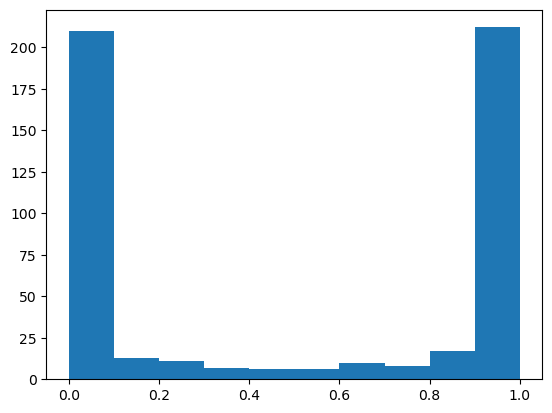

In [55]:
plt.hist(predictions)
plt.show()

連続値は0から1まで歪んでいますが、0.1から0.9までの間で、しきい値を調整するにはちょうど良さそうです。

In [56]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.3, 1, 0))

col_0,0,1
Churn?_True.,,
0,228,25
1,6,241


例えば、しきい値を0.5から0.3まで減らしてみたとき、true positives は 4 つ、false positives は 9 つ増え、false negatives は 4 つ減りました。全体からみると小さな値ですが、全体の約3%の顧客が、しきい値の変更で、予測結果が変わりました。ここで5名にインセンティブを与えることによって、インセンティブのコストが掛かりますが、3名の顧客を引き止めることができるかもしれません。
つまり、最適な閾値を決めることは、実世界の問題を機械学習で解く上で重要なのです。これについてもう少し広く議論し、仮説的なソリューションを考えたいと思います。

### 5-2.推論エラーのコスト

2値分類の問題においては、しきい値に注意しなければならないという、似たような状況に直面することが多いです。それ自体は問題ではありません。もし、出力の連続値が2クラスで完全に別れていれば、MLを使うことなく単純なルールで解くことができると考えられます。

重要なこととして、MLモデルを本番環境に導入する際、モデルが false positives と false negatives に誤って入れたときのコストがあげられます。しきい値の選択は4つの指標に影響を与えます。4つの指標に対して、ビジネス上の相対的なコストを考える必要があるでしょう。

#### コストの割当

携帯電話会社の離反の問題において、コストとはなんでしょうか？コストはビジネスでとるべきアクションに結びついています。いくつかの仮定をおいてみましょう。

まず、true negatives のコストとして \$0 を割り当てます。満足しているお客様を正しく認識できていれば何も実施しません。

false negatives が一番問題で、なぜなら、離反していく顧客を正しく予測できないからです。顧客を失えば、再獲得するまでに多くのコストを払う必要もあり、例えば逸失利益、広告コスト、管理コスト、販売管理コスト、電話の購入補助金などがあります。インターネットを簡単に検索してみると、そのようなコストは数百ドルとも言われ、ここでは `$500` としましょう。これが false negatives に対するコストです。

最後に、離反していくと予測された顧客に `$100` のインセンティブを与えることを考えましょう。
携帯電話会社がそういったインセンティブを提供するなら、2回くらいは離反の前に考え直すかもしれません。これは true positive と　false negative のコストになります。false positives の場合 (顧客は満足していて、モデルが誤って離反しそうと予測した場合)、 `$100` のインセンティブは捨てることになります。その `$100` を効率よく消費してしまうかもしれませんが、優良顧客へのロイヤリティを増やすという意味では悪くないかもしれません。


### 5-3.最適な閾値を探す

false negatives が false positives よりもコストが高いことは説明しました。そこで、顧客の数ではなく、コストを最小化するように、しきい値を最適化することを考えましょう。コストの関数は以下のようなものになります。

```txt
$500 * FN(C) + $0 * TN(C) + $100 * FP(C) + $100 * TP(C)
```

FN(C) は false negative の割合で、しきい値Cの関数です。同様にTN, FP, TP も用意します。この関数の値が最小となるようなしきい値Cを探します。
最も単純な方法は、候補となる閾値で何度もシミュレーションをすることです。以下では100個の値に対してループで計算を行います。

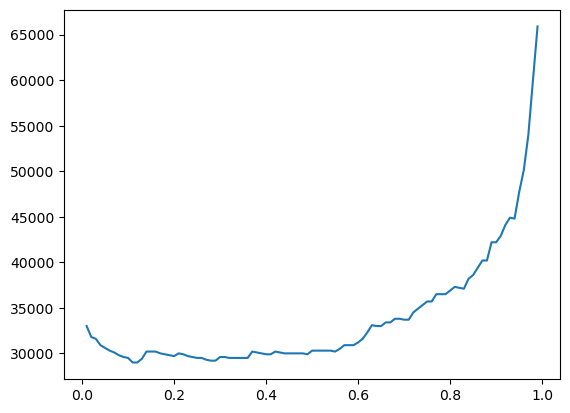

コストが最小となるしきい値は: 0.11 であり、その際のコストは: 29000 です。


In [57]:
cutoffs = np.arange(0.01, 1, 0.01)
costs = []

for c in cutoffs:
    _predictions = pd.Categorical(np.where(predictions > c, 1, 0), categories=[0, 1])
    matrix_a = np.array([[0, 100], [500, 100]])
    matrix_b = pd.crosstab(index=test_data.iloc[:, 0], columns=_predictions, dropna=False)
    costs.append(np.sum(np.sum(matrix_a * matrix_b)))

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.show()
print('コストが最小となるしきい値は:', cutoffs[np.argmin(costs)], 'であり、その際のコストは:', np.min(costs),'です。')